# TCC

- Problema: localização de minérios
- Solução: aplicação de aprendizado de máquina com uso de dados de espectrometria e gravimetria para classificar locais com alta probabilidade de conter minérios
  - Minério de estudo: cobre

---
- Processamento:
  - Problemas: 
    - conversão de coordenadas para latitude/longitude e uso de 2 casas decimais para evitar perda de dados durante mesclagem de dados

  - Aprendizado de máquina:
    - desbalanceamento entre classes

---

Ref Github: https://github.com/lszam/mineralexp

In [65]:
import os
import sys
import time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    classification_report,
    precision_recall_curve,
    average_precision_score,
)
import shap
import folium
from branca.element import Figure

filterwarnings("ignore")

sys.tracebacklimit = 0

In [66]:
dir_projeto = Path(os.getcwd()).parent.absolute().parent.absolute()
data_dir = Path(dir_projeto, "Output", "tcc", "v1")
shp_dir = Path(data_dir, "shp")

In [67]:
# arredondamento de casas decimais para conversão de coordenadas geográficas
arredondamento = 2

## funções

### coordenadas geográficas

In [68]:
def utm_to_latlon(
    df: pd.DataFrame,
    x_col: str = "X",
    y_col: str = "Y",
    utm_zone: int = 22,
    southern_hemisphere: bool = True,
    arredondamento: int = 3,
) -> pd.DataFrame:
    """
    Convert UTM coordinates to latitude/longitude (WGS84)

    Parameters:
    - df: DataFrame containing coordinates
    - x_col: Column name for easting (UTM X)
    - y_col: Column name for northing (UTM Y)
    - utm_zone: UTM zone number (Brazil is mostly zones 22-25)
    - southern_hemisphere: True for southern hemisphere (Brazil)

    Returns:
    DataFrame with new 'longitude' and 'latitude' columns
    """
    # Create UTM coordinate system
    utm = pyproj.Proj(proj="utm", zone=utm_zone, south=southern_hemisphere)

    # Create WGS84 coordinate system
    wgs84 = pyproj.Proj(proj="latlong", datum="WGS84")

    # Convert coordinates
    lon, lat = pyproj.transform(utm, wgs84, df[x_col].values, df[y_col].values)

    # Add to DataFrame
    df = df.copy()
    df["longitude"] = lon
    df["latitude"] = lat

    df["longitude"] = df["longitude"].round(arredondamento)
    df["latitude"] = df["latitude"].round(arredondamento)

    return df


def convert_shapefile_to_latlon(shapefile_path: Path) -> gpd.GeoDataFrame:
    """
    Read a shapefile and convert coordinates to latitude/longitude (WGS84)

    Parameters:
    - shapefile_path: path for the shapefile

    Returns:
    GeoDataFrame
    """
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs is None:
        # Assuming it's in the same UTM as your other data
        gdf.crs = "+proj=utm +zone=22 +south +datum=WGS84 +units=m +no_defs"
    gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)
    if not os.path.basename(shapefile_path) == "estruturas_ln.shp":
        gdf["longitude"] = gdf.geometry.x
        gdf["latitude"] = gdf.geometry.y
    return gdf

### processamento

In [69]:
def clusterizar_coordenadas_geograficas(df: pd.DataFrame, n_clusters: np.int16 = 8) -> pd.DataFrame:
    """Aplica clusterização nas coordenadas geográficas para modelo de aprendizado de máquina,
    como feature engineering

    Args:
        df (pd.DataFrame): dataframe com dados de coordenadas geográficas
        n_clusters (np.int16, optional): número de clusters. Defaults to 8.

    Returns:
        pd.DataFrame: dataframe com clusters de coordenadas
    """
    coords = df[["longitude", "latitude"]].values
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(coords)
    df["geo_cluster"] = kmeans.labels_
    dict_map_idx_lon = dict(zip(df.index, df["longitude"]))
    dict_map_idx_lat = dict(zip(df.index, df["latitude"]))
    df = df.drop(["longitude", "latitude"], axis=1)
    return df, dict_map_idx_lon, dict_map_idx_lat


### aprendizado de máquina

In [70]:
def split_data(X, y, test_size: np.float16 = 0.3) -> tuple:
    """Divide dados de treino e teste

    Args:
        df (pd.DataFrame): dataframe com dados
        test_size (np.float16, optional): tamanho dos dados de teste. Defaults to 0.3.

    Returns:
        tuple: _description_
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=420,
        stratify=y,  # dados desbalanceados
    )

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class balance - Train: {y_train.mean():.2%}, Test: {y_test.mean():.2%}")

    return X_train, X_test, y_train, y_test

In [71]:
def pipeline_ml(
    models: dict,
    cv: StratifiedKFold,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
) -> dict:
    """Pipeline para modelos de aprendizado de máquina, realizando treinamento com validação cruzada e avaliação

    Args:
        models (dict): dicionário com modelos
        cv (StratifiedKFold): validação cruzada
        X_train (np.array): array de dados independentes de treino
        X_test (np.array): array de dados independentes de teste
        y_train (np.array): array de dados dependentes de treino
        y_test (np.array): array de dados dependentes de teste
    """
    results = {}
    for name, model in models.items():
        start_train = time.perf_counter()

        # Create pipeline (scale for logistic regression)
        if name == "Logistic Regression":
            pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        else:
            pipe = model

        # Cross-validation
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipe.fit(X_train, y_train)

        print("\n")
        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {"model": pipe, "cv_mean_auc": cv_scores.mean(), "cv_std_auc": cv_scores.std()}

        print(f"{name} - CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

        # Evaluate on test set
        if hasattr(pipe, "predict_proba"):
            evaluate_model(pipe, X_test, y_test)

    return results


def evaluate_model(model, X_test: np.array, y_test: np.array) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal Decision Threshold: {optimal_threshold:.3f}")
    print("\n")


def evaluate_model_custom(model, X_test: np.array, y_test: np.array, threshold: float) -> None:
    """Função para avaliar o modelo

    Args:
        model (_type_): _description_
        X_test (np.array): array de dados independentes de teste
        y_test (np.array): array de dados dependentes de teste
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_custom = (y_proba >= threshold).astype(int)

    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_custom):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_custom))

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal Decision Threshold: {optimal_threshold:.3f}")
    print("\n")

In [72]:
def pipeline_ml_undersampling(pipelines, cv, X_train, X_test, y_train, y_test) -> dict:
    results = {}
    # Training and evaluation
    for name, pipeline in pipelines.items():
        print(f"\n=== Training {name} ===")

        start_train = time.perf_counter()

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipeline.fit(X_train, y_train)

        print(f"Tempo total de treino {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

        # Store results
        results[name] = {
            "model": pipeline,
            "cv_mean_auc": cv_scores.mean(),
            "cv_std_auc": cv_scores.std(),
        }

        # Test set evaluation
        if hasattr(pipeline, "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            avg_precision = average_precision_score(y_test, y_proba)

            print(f"Test ROC-AUC: {roc_auc:.3f}")
            print(f"Test F1 Score: {f1:.3f}")
            print(f"Test Average Precision: {avg_precision:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

            # Store additional metrics
            results[name].update({
                "test_roc_auc": roc_auc,
                "test_f1": f1,
                "test_avg_precision": avg_precision,
                "optimal_threshold": optimal_threshold,
            })

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
        print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
        print(f"Test F1: {res['test_f1']:.3f}")
        print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

In [73]:
def pipeline_ml_oversampling(pipelines, cv, X_train, X_test, y_train, y_test) -> dict:
    results = {}

    min_minority_samples = min([
        np.sum(y_train[test_idx] == 1) for _, test_idx in cv.split(X_train, y_train)
    ])

    k_neighbors = min(5, min_minority_samples - 1) if min_minority_samples > 1 else 1

    # Training and evaluation
    for name, model in pipelines.items():
        print(f"\n=== Training {name} ===")

        start_train = time.perf_counter()

        # Create pipeline with SMOTE
        pipeline = ImbPipeline([
            ("smote", SMOTE(random_state=42, sampling_strategy="auto", k_neighbors=k_neighbors)),
            ("classifier", model),
        ])

        try:
            # Cross-validation
            cv_scores = cross_val_score(
                pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1, error_score="raise"
            )

            # Full training
            pipeline.fit(X_train, y_train)

            print(f"Training time {name}: {round((time.perf_counter() - start_train) / 60, 2)} min")

            # Store results
            results[name] = {
                "model": pipeline,
                "cv_mean_auc": cv_scores.mean(),
                "cv_std_auc": cv_scores.std(),
            }

            print(f"CV AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

            # Test set evaluation
            if hasattr(model, "predict_proba"):
                y_proba = pipeline.predict_proba(X_test)[:, 1]
                y_pred = pipeline.predict(X_test)

                # Calculate metrics
                roc_auc = roc_auc_score(y_test, y_proba)
                f1 = f1_score(y_test, y_pred)
                avg_precision = average_precision_score(y_test, y_proba)

                print(f"Test ROC-AUC: {roc_auc:.3f}")
                print(f"Test F1 Score: {f1:.3f}")
                print(f"Test Average Precision: {avg_precision:.3f}")
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred))

                # Find optimal threshold
                precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
                f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
                optimal_idx = np.argmax(f1_scores)
                optimal_threshold = thresholds[optimal_idx]
                print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

                # Store additional metrics
                results[name].update({
                    "test_roc_auc": roc_auc,
                    "test_f1": f1,
                    "test_avg_precision": avg_precision,
                    "optimal_threshold": optimal_threshold,
                })

        except Exception as e:
            print(f"Failed to train {name}: {str(e)}")
            results[name] = {"error": str(e)}

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        if "error" in res:
            print(f"Training failed: {res['error']}")
        else:
            print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
            if "test_roc_auc" in res:
                print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
                print(f"Test F1: {res['test_f1']:.3f}")
                print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

In [74]:
def pipeline_ml_smote_tomek(pipelines, cv, X_train, X_test, y_train, y_test) -> dict:
    results = {}

    # Training and evaluation
    for name, model in pipelines.items():
        print(f"\n=== Training {name} ===")

        start_train = time.perf_counter()

        # Create pipeline with SMOTETomek
        pipeline = ImbPipeline([
            (
                "smote_tomek",
                SMOTETomek(
                    random_state=42,
                    tomek=TomekLinks(sampling_strategy="majority"),
                    smote=SMOTE(k_neighbors=2),  # Reduce from default 5
                ),
            ),
            ("classifier", model),
        ])

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)

        # Full training
        pipeline.fit(X_train, y_train)

        print(
            f"Total training time for {name}: {round((time.perf_counter() - start_train) / 60, 2)} min"
        )

        # Store results
        results[name] = {
            "model": pipeline,
            "cv_mean_auc": cv_scores.mean(),
            "cv_std_auc": cv_scores.std(),
        }

        # Test set evaluation
        if hasattr(model, "predict_proba"):  # Check the original model for predict_proba
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            y_pred = pipeline.predict(X_test)

            # Calculate metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            avg_precision = average_precision_score(y_test, y_proba)

            print(f"Test ROC-AUC: {roc_auc:.3f}")
            print(f"Test F1 Score: {f1:.3f}")
            print(f"Test Average Precision: {avg_precision:.3f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Decision Threshold: {optimal_threshold:.3f}")

            # Store additional metrics
            results[name].update({
                "test_roc_auc": roc_auc,
                "test_f1": f1,
                "test_avg_precision": avg_precision,
                "optimal_threshold": optimal_threshold,
            })

    # Compare model performance
    print("\n=== Model Comparison ===")
    for name, res in results.items():
        print(f"\n{name}:")
        print(f"CV AUC: {res['cv_mean_auc']:.3f} (±{res['cv_std_auc']:.3f})")
        if "test_roc_auc" in res:
            print(f"Test ROC-AUC: {res['test_roc_auc']:.3f}")
            print(f"Test F1: {res['test_f1']:.3f}")
            print(f"Optimal Threshold: {res['optimal_threshold']:.3f}")

    return results

## leitura e processamento

- leitura dos shapefiles com ocorrências de metais/minas

In [75]:
# ouro = gpd.read_file(Path(shp_dir, 'ocorrencias_Au.shp'))
# # cobre = gpd.read_file(Path(shp_dir, 'ocorrencias_Cu.shp'))
# ferro = gpd.read_file(Path(shp_dir, 'ocorrencias_Fe.shp'))
# # manganes = gpd.read_file(Path(shp_dir, 'ocorrencias_Mn.shp'))
# # niquel = gpd.read_file(Path(shp_dir, 'ocorrencias_Ni.shp'))
# # chumbo = gpd.read_file(Path(shp_dir, 'ocorrencias_Pb.shp'))
# # estanho = gpd.read_file(Path(shp_dir, 'ocorrencias_Sn.shp'))
# minas = gpd.read_file(Path(shp_dir, 'minas.shp'))
# estruturas = gpd.read_file(Path(shp_dir, 'estruturas_ln.shp'))

# ! leitura dos arquivos com conversão para latitude/longitude
ouro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Au.shp"))
cobre = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Cu.shp"))
ferro = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Fe.shp"))
# manganes = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Mn.shp'))
niquel = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Ni.shp"))
chumbo = convert_shapefile_to_latlon(Path(shp_dir, "ocorrencias_Pb.shp"))
# estanho = convert_shapefile_to_latlon(Path(shp_dir, 'ocorrencias_Sn.shp'))

minas = convert_shapefile_to_latlon(Path(shp_dir, "minas.shp"))

estruturas = convert_shapefile_to_latlon(Path(shp_dir, "estruturas_ln.shp"))

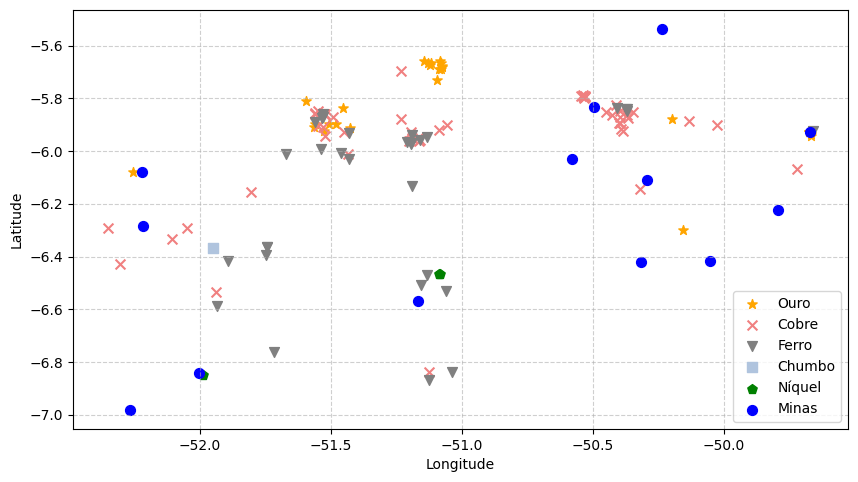

In [76]:
# https://matplotlib.org/stable/api/markers_api.html
# https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots(figsize=(10, 10))
ouro.plot(ax=ax, color="orange", marker="*", markersize=50, label="Ouro")
cobre.plot(ax=ax, color="lightcoral", marker="x", markersize=50, label="Cobre")
ferro.plot(ax=ax, color="gray", marker="v", markersize=50, label="Ferro")
chumbo.plot(ax=ax, color="lightsteelblue", marker="s", markersize=50, label="Chumbo")
niquel.plot(ax=ax, color="green", marker="p", markersize=50, label="Níquel")
minas.plot(ax=ax, color="blue", marker="o", markersize=50, label="Minas")
# estruturas.plot(ax=ax, color='blue', alpha=0.5, label='Estruturas')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(visible=True, alpha=0.6, linestyle="--")
plt.legend(loc="lower right")
plt.show()

In [77]:
df_minas = pd.DataFrame(minas)
df_minas = df_minas[["longitude", "latitude"]]
df_minas["longitude"] = df_minas["longitude"].round(arredondamento)
df_minas["latitude"] = df_minas["latitude"].round(arredondamento)

df_minas.head(3)

,longitude,latitude
0,-52.22,-6.28
1,-52.22,-6.08
2,-51.16,-6.57


In [78]:
# ouro, cobre, ferro, manganes, niquel, chumbo, estanho
df_minerio = pd.DataFrame(cobre)
df_minerio = df_minerio[["longitude", "latitude"]]
df_minerio["longitude"] = df_minerio["longitude"].round(arredondamento)
df_minerio["latitude"] = df_minerio["latitude"].round(arredondamento)
df_minerio = df_minerio.drop_duplicates(subset=['longitude', 'latitude'])
df_minerio["ocorrencia"] = 1

print(df_minerio.shape)
df_minerio.head(3)

(42, 3)


,longitude,latitude,ocorrencia
0,-52.30,-6.43,1
1,-52.35,-6.29,1
2,-51.56,-5.86,1


- leitura dos dados de espectrometria

  - dados:
    - Fator F: valores altos para rochas alteradas por fluidos que carregam metais
    - Kd: abundância de potássio
    - Ud: abundância de urânio

In [79]:
spec_data = pd.read_csv(
    Path(data_dir, "dados_gamaespectrometria_filtrados.csv"),
    dtype={
        "XUTM": np.float32,
        "YUTM": np.float32,
        "FatorF": np.float32,
        "Kd": np.float32,
        "Ud": np.float32,
    },
)
# spec_data.rename(columns={"XUTM": "X", "YUTM": "Y"}, inplace=True)
spec_data = utm_to_latlon(spec_data, x_col="XUTM", y_col="YUTM", arredondamento=arredondamento)
spec_data = spec_data.drop_duplicates(subset=['longitude', 'latitude'])
spec_data = spec_data.drop(["XUTM", "YUTM"], axis=1)
print(spec_data.shape)
spec_data.head(3)

(116745, 5)


,FatorF,Kd,Ud,longitude,latitude
0,0.001366,-71.005653,-0.349341,-53.00,-8.12
5,0.011905,-6.249339,-0.521728,-52.99,-8.12
13,0.017009,-0.655671,-2.454801,-52.98,-8.12


- leitura dos dados de gravimetria

  - dados:
    - grav_residual190km_qht: gravidade residual a 190 km
    - grav_residual100km: gravidade residual a 100 km
    - maq_asvi: 
    - maq_qt: 

In [80]:
grav_data = pd.read_csv(
    Path(data_dir, "dados_gravmag_filtrados_v2.csv"),
    dtype={
        "X": np.float32,
        "Y": np.float32,
        "grav_residual190km_ght": np.float32,
        "grav_residual100km": np.float32,
        "mag_asvi": np.float32,
        "mag_gt": np.float32,
    },
)
grav_data = utm_to_latlon(grav_data, x_col="X", y_col="Y", arredondamento=arredondamento)
grav_data = grav_data.drop_duplicates(subset=['longitude', 'latitude'])
grav_data = grav_data.drop(["X", "Y"], axis=1)
print(grav_data.shape)
grav_data.head(3)

(114011, 6)


,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,longitude,latitude
0,0.000501,-1.943505,67.472176,0.008145,-51.42,-8.12
1,0.000573,-1.592606,64.604439,0.008208,-51.41,-8.12
3,0.000560,-1.101486,60.097729,0.008015,-51.40,-8.12


- mesclar dfs com dados de gravimetria e espectrometria

In [81]:
df_merge_data = pd.merge(spec_data, grav_data, how="inner", on=["longitude", "latitude"])
df_merge_data = df_merge_data[
    [
        "longitude",
        "latitude",
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
    ]
]
df_merge_data = df_merge_data.drop_duplicates(subset=['longitude', 'latitude'])
print(df_merge_data.shape)
df_merge_data.head(3)

(113918, 9)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt
0,-51.42,-8.12,0.078172,-0.308638,0.256699,0.000501,-1.943505,67.472176,0.008145
1,-51.41,-8.12,0.098377,0.222405,0.242000,0.000573,-1.592606,64.604439,0.008208
2,-51.40,-8.12,0.206461,0.604988,0.279642,0.000560,-1.101486,60.097729,0.008015


- criar dataframes base para aprendizado de máquina

In [82]:
# # ! aplica knn para pontos de ocorrência de ouro mais próximos
# coords_merge = df_merge_data_reduced[["longitude", "latitude"]].values
# coords_minerio = df_minerio[["longitude", "latitude"]].values

# nbrs = NearestNeighbors(n_neighbors=1).fit(coords_merge)
# distances, indices = nbrs.kneighbors(coords_minerio)

# df_minerio_merge = df_merge_data_reduced.copy()
# df_minerio_merge["ocorrencia"] = 0

# for pos in indices.flatten():
#     df_minerio_merge.loc[pos, "ocorrencia"] = 1

In [83]:
# shape do merge == df_minerio -> garantia de que há os mesmos pontos
pd.merge(df_merge_data, df_minerio, how="inner", on=["longitude", "latitude"]).shape

(42, 10)

In [84]:
# cria df com inner join
df_minerio_inner = pd.merge(df_merge_data, df_minerio, how="inner", on=["longitude", "latitude"])
print(df_minerio_inner.shape)
df_minerio_inner.head(3)

(42, 10)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-51.12,-6.84,0.219333,0.471614,0.237940,0.001560,-0.409200,55.809669,0.012083,1
1,-51.94,-6.53,0.154298,-0.720971,0.287064,0.000267,-1.958070,118.654922,0.042235,1
2,-52.30,-6.43,0.039492,-4.546056,0.058103,0.000733,4.922951,57.303692,0.012998,1


- Muitos pontos na base de dados -> desbalanço muito forte de classes
    - Redução da base: corte da área e reamostragem da base

In [85]:
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_minerio.shape[0]}")

Mesclagem de dados (espec + gravim): 113918
Mesclagem de dados (espec + gravim): 42


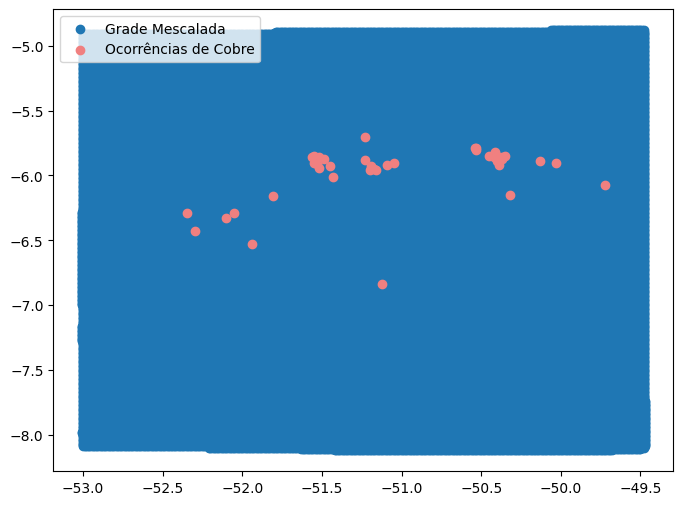

In [86]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_merge_data['longitude'], df_merge_data['latitude'], label='Grade Mescalada')
ax.scatter(df_minerio['longitude'], df_minerio['latitude'], color='lightcoral', label='Ocorrências de Cobre')
plt.legend()
plt.show()

In [87]:
# redução da área geográfica
min_lat, max_lat = df_minerio['latitude'].min(), df_minerio['latitude'].max()
min_lon, max_lon = df_minerio['longitude'].min(), df_minerio['longitude'].max()

padding = 0.1
lat_min_padded = min_lat - padding
lat_max_padded = max_lat + padding
lon_min_padded = min_lon - padding
lon_max_padded = max_lon + padding

df_merge_data_clipped = df_merge_data[
    (df_merge_data['latitude'] >= lat_min_padded) & (df_merge_data['latitude'] <= lat_max_padded) &
    (df_merge_data['longitude'] >= lon_min_padded) & (df_merge_data['longitude'] <= lon_max_padded)
]

# reamostragem dos dados via pandas
df_merge_data_reduced = df_merge_data_clipped.sample(frac=0.03, random_state=42)

print(df_merge_data_reduced.shape)

(1133, 9)


In [88]:
# concatena inner join com reamostragem
df_minerio_merge = pd.concat([df_merge_data_reduced, df_minerio_inner], axis=0, ignore_index=True)
df_minerio_merge = df_minerio_merge.fillna(0)
df_minerio_merge['ocorrencia'] = df_minerio_merge['ocorrencia'].astype(int)
print(df_merge_data_reduced.shape)
df_minerio_merge.head(3)

(1133, 9)


,longitude,latitude,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,ocorrencia
0,-50.50,-5.95,0.097683,0.352167,-0.189589,0.001736,-6.499377,97.921883,0.016415,0
1,-51.88,-6.49,0.056461,-0.311667,-0.368172,0.000978,0.110644,75.368767,0.033381,0
2,-51.39,-6.51,0.037565,-0.021877,-0.358604,0.000427,-1.090122,40.889549,0.019091,0


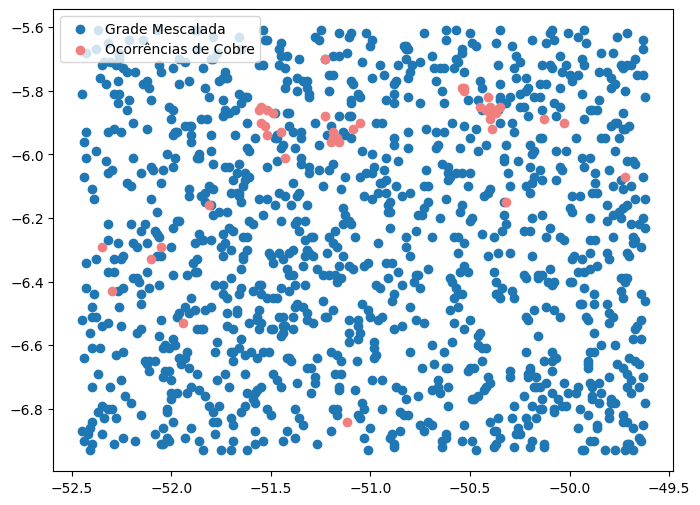

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 0]["longitude"],
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 0]["latitude"],
    label="Grade Mescalada",
)
ax.scatter(
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 1]["longitude"],
    df_minerio_merge[df_minerio_merge["ocorrencia"] == 1]["latitude"],
    color="lightcoral",
    label="Ocorrências de Cobre",
)
plt.legend()
plt.show()

In [90]:
print(f"Dados de espectrometria: {spec_data.shape[0]}")
print(f"Dados de gravimetria: {grav_data.shape[0]}")
print(f"Mesclagem de dados (espec + gravim): {df_merge_data.shape[0]}")
print(f"Redução de mesclagem de dados (espec + gravim): {df_merge_data_reduced.shape[0]}")
print(f"Mesclagem com cobre (espec + gravim + cobre): {df_minerio_merge.shape[0]}")

Dados de espectrometria: 116745
Dados de gravimetria: 114011
Mesclagem de dados (espec + gravim): 113918
Redução de mesclagem de dados (espec + gravim): 1133
Mesclagem com cobre (espec + gravim + cobre): 1175


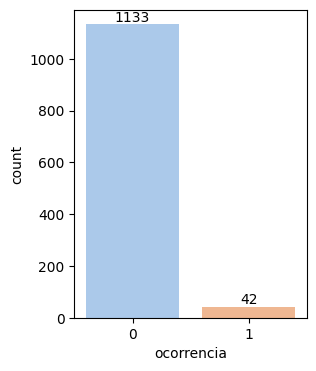

In [91]:
plt.figure(figsize=(3, 4))
ax = sns.countplot(x="ocorrencia", data=df_minerio_merge, palette="pastel")
for i in ax.containers:
    ax.bar_label(i)

In [92]:
print(
    "Cobre:",
    round(df_minerio_merge["ocorrencia"].value_counts()[1] / len(df_minerio_merge) * 100, 2),
    "% do dataset",
)

Cobre: 3.57 % do dataset


- clusterização de coordenadas geográficas
  - n_clusters = default 8 (tutorial) -> parametrizado

In [93]:
df_minerio_merge, dict_map_idx_lon, dict_map_idx_lat = clusterizar_coordenadas_geograficas(
    df=df_minerio_merge
)

In [94]:
df_minerio_merge = df_minerio_merge[
    [
        "geo_cluster",
        "FatorF",
        "Kd",
        "Ud",
        "grav_residual190km_ght",
        "grav_residual100km",
        "mag_asvi",
        "mag_gt",
        "ocorrencia",
    ]
]

## aprendizado de máquina

### split treino-teste

- split padrão -> 70% treino e 30% teste

In [95]:
X = df_minerio_merge.drop(["ocorrencia"], axis=1)
y = df_minerio_merge["ocorrencia"].values
X_train, X_test, y_train, y_test = split_data(X, y)

Train shape: (822, 8), Test shape: (353, 8)
Class balance - Train: 3.53%, Test: 3.68%


### pipeline

In [96]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = pipeline_ml(models, cv, X_train, X_test, y_train, y_test)



Tempo total de treino Random Forest: 0.19 min
Random Forest - CV AUC: 0.756 (±0.053)
ROC-AUC: 0.730
F1 Score: 0.000

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       340
           1       0.00      0.00      0.00        13

    accuracy                           0.96       353
   macro avg       0.48      0.50      0.49       353
weighted avg       0.93      0.96      0.95       353


Optimal Decision Threshold: 0.220




Tempo total de treino Logistic Regression: 0.11 min
Logistic Regression - CV AUC: 0.657 (±0.099)
ROC-AUC: 0.720
F1 Score: 0.128

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       340
           1       0.07      0.69      0.13        13

    accuracy                           0.65       353
   macro avg       0.53      0.67      0.45       353
weighted avg       0.95      0.65      0.76       353


Optimal Deci

---

- Random Forest

    - Teve o melhor F1-score entre os modelos (0.756 CV AUC), mas ainda assim falhou completamente em prever a classe 1 (F1=0).

    - A alta precisão para a classe 0 (96%) com recall perfeito (100%) indica que o modelo está simplesmente classificando tudo como classe 0.


- Regressão Logística

    - Mostrou algum poder preditivo para a classe 1 (recall=69%), mas com precisão muito baixa (7%).

    - O threshold ótimo foi o mais alto (0.593), sugerindo que o modelo é conservador.


- SVM (Support Vector Machine)

    - Teve o pior desempenho geral (AUC=0.581), com comportamento errático (alto recall mas baixíssima precisão para classe 1).


- XGBoost

    - Obteve o melhor ROC-AUC (0.817) na validação, mas ainda com desempenho ruim na classe 1 (F1=0.105).

    - Mostrou o melhor equilíbrio entre as métricas, mas ainda insuficiente.

---

- Problema Principal: Desbalanceamento de Classes

    - O principal problema parece ser o desequilíbrio extremo das classes. Técnicas como oversampling da classe minoritária, undersampling da classe majoritária ou uso de pesos de classe podem ajudar.

    - Ajuste fino dos thresholds de classificação pode melhorar o F1-score.

In [97]:
# fig, axs = plt.subplots(1, 4, figsize=(10, 4))
# for mdl, ax in zip(models.keys(), axs.flatten()):
#     y_proba = models[mdl].predict_proba(X_test)[:, 1]
#     fpr, tpr, threshold = roc_curve(y_test, y_proba)
#     roc_auc = auc(fpr, tpr)

#     # plot
#     ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
#     ax.plot([0, 1], [0, 1], "r--")
#     ax.legend()
#     ax.grid(visible=True, alpha=0.6, linestyle="--")
#     ax.set_title(mdl)
# plt.tight_layout()
# plt.show()

- Soluções:
  - Existem diferentes soluções:
    - undersampling da classe majoritária (0)
    - oversampling da classe minoritária (1)

### pipeline undersampling

In [98]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

# Create pipelines with undersampling
pipelines_unders = {}
for name, model in models.items():
    if name in {"Logistic Regression", "SVM"}:
        # Adiciona StandardScaler para modelos sensíveis à escala
        pipelines_unders[name] = make_pipeline(
            RandomUnderSampler(random_state=42), StandardScaler(), model
        )
    else:
        pipelines_unders[name] = make_pipeline(RandomUnderSampler(random_state=42), model)

results_unders = pipeline_ml_undersampling(pipelines_unders, cv, X_train, X_test, y_train, y_test)


=== Training Random Forest ===
Tempo total de treino Random Forest: 0.14 min
Test ROC-AUC: 0.763
Test F1 Score: 0.162
Test Average Precision: 0.198

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       340
           1       0.09      0.69      0.16        13

    accuracy                           0.74       353
   macro avg       0.54      0.72      0.50       353
weighted avg       0.95      0.74      0.82       353

Optimal Decision Threshold: 0.880

=== Training Logistic Regression ===
Tempo total de treino Logistic Regression: 0.05 min
Test ROC-AUC: 0.744
Test F1 Score: 0.113
Test Average Precision: 0.092

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       340
           1       0.06      0.62      0.11        13

    accuracy                           0.65       353
   macro avg       0.52      0.63      0.45       353
weighted 

---

- Random Forest

    - Melhor desempenho geral (ROC-AUC: 0.763 / F1-Score: 0.162 para classe 1).

    - Recall alto para classe 1 (69%), mas precisão muito baixa (9%) – muitos falsos positivos.

    - Threshold alto (0.88) indica que o modelo só classifica como "1" quando tem alta confiança.

    - AUC consistente (CV: 0.757 ± 0.066), mostrando robustez.

- Regressão Logística

    - Desempenho moderado (ROC-AUC: 0.744 / F1-Score: 0.113).

    - Recall razoável (62%), mas precisão extremamente baixa (6%) – quase inútil na prática.

    - Threshold mais baixo (0.585), refletindo menor confiança nas previsões.

    - AUC estável (CV: 0.700 ± 0.070), porém ainda limitado.

- SVM

    - Resultados similares ao Random Forest (ROC-AUC: 0.735 / F1-Score: 0.133).

    - Recall aceitável (54%), mas precisão muito baixa (8%).

    - Threshold intermediário (0.639), equilibrando um pouco mais as classes.

    - Alta variabilidade no CV AUC (±0.096), indicando sensibilidade aos dados.

- XGBoost

    - Melhor ROC-AUC (0.779), mas F1-Score baixo (0.114) devido à precisão péssima (6%).

    - Recall altíssimo (77%), mas com muitos falsos positivos (precisão inaceitável).

    - Threshold extremamente alto (0.988), sugerindo que o modelo quase nunca prevê "1".

    - Alta variabilidade no CV (±0.120), possivelmente devido ao desbalanceamento residual.

---

- Problemas Identificados

    - Trade-off entre Recall e Precisão

        - Todos os modelos priorizaram recall para a classe 1, mas com precisão muito baixa (6–9%).

        - Isso gera muitos falsos positivos, inviabilizando o uso em cenários reais (ex.: custo alto de ações baseadas em previsões erradas).

    - Thresholds Otimizados, mas Insuficientes

        - Ajustar o threshold melhorou o recall, mas não resolveu a baixa precisão.

        - XGBoost teve o pior caso: threshold = 0.988 praticamente ignora a classe 1.

    - Undersampling Pode Ter Removido Informação Relevante

        - A redução da classe majoritária pode ter eliminado padrões importantes, afetando a generalização.

        - Alternativas: Testar SMOTE (oversampling) ou abordagens híbridas.

    - AUC Alto ≠ Desempenho Prático

        - XGBoost teve o melhor AUC (0.779), mas não se traduziu em F1-Score útil.

        - Métrica mais relevante: Average Precision (AP) – todos os modelos tiveram AP < 0.2, confirmando a dificuldade com a classe 1.

---

### pipeline oversampling

In [99]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

# Create pipelines with overrsampling
pipelines_overs = {}
for name, model in models.items():
    if name in {"Logistic Regression", "SVM"}:
        # Add StandardScaler for Logistic Regression
        pipelines_overs[name] = make_pipeline(StandardScaler(), model)
    else:
        pipelines_overs[name] = make_pipeline(model)

results_overs = pipeline_ml_oversampling(
    pipelines=pipelines_overs, cv=cv, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
)


=== Training Random Forest ===
Training time Random Forest: 0.05 min
CV AUC: 0.775 (±0.130)
Test ROC-AUC: 0.731
Test F1 Score: 0.250
Test Average Precision: 0.226

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       340
           1       0.27      0.23      0.25        13

    accuracy                           0.95       353
   macro avg       0.62      0.60      0.61       353
weighted avg       0.95      0.95      0.95       353

Optimal Decision Threshold: 0.720

=== Training Logistic Regression ===
Training time Logistic Regression: 0.02 min
CV AUC: 0.648 (±0.103)
Test ROC-AUC: 0.690
Test F1 Score: 0.113
Test Average Precision: 0.077

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       340
           1       0.06      0.62      0.11        13

    accuracy                           0.65       353
   macro avg       0.52      0.63

---

- Random Forest

    - Melhora no F1-Score (0.250 vs 0.162 com undersampling), mas ainda precisão baixa (27%) para classe 1.

    - Recall piorou (23% vs 69% com undersampling), indicando que o SMOTE pode ter introduzido ruído.

    - AUC razoável (0.731), mas com alta variabilidade no CV (±0.130).

    - Threshold mais baixo (0.72), mostrando maior disposição a prever classe 1.

- Regressão Logística

    - Pior desempenho geral (F1-Score: 0.113 / ROC-AUC: 0.690).

    - Recall alto (62%), mas precisão catastrófica (6%) – quase inútil na prática.

    - Threshold baixo (0.566) reflete baixa confiança nas previsões.

    - AUC consistentemente baixo (CV: 0.648), indicando incapacidade de aprender padrões complexos.

- SVM

    - Melhor F1-Score (0.273) entre todos, com recall aceitável (69%) e precisão melhor (17%).

    - ROC-AUC excelente (0.863), sugerindo boa capacidade discriminativa.

    - Threshold equilibrado (0.68), mas ainda com muitos falsos positivos.

    - Alta variabilidade no CV (±0.130), exigindo validação cruzada rigorosa.

- XGBoost

    - AUC alto (0.803), mas F1-Score mediano (0.238) devido à precisão ruim (17%).

    - Recall razoável (38%), mas threshold extremo (0.996) – praticamente só prevê classe 1 com certeza absoluta.

    - CV AUC alto (0.780), porém com alta variabilidade (±0.146), indicando instabilidade.

---

- O oversampling com SMOTE melhorou a detecção da classe 1, especialmente no SVM (F1: 0.273, ROC-AUC: 0.863). No entanto:

    - Precisão ainda é baixa (17–27%), o que pode ser inviável em cenários reais.

    - XGBoost e Random Forest tiveram desempenho irregular, com trade-offs claros.

    - Próximos passos: Otimizar SMOTE, testar ensembles híbridos e focar no SVM como modelo promissor.

---

### pipeline combinação oversampling + undersampling

Ref: https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset

In [100]:
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42, penalty="l2", solver="lbfgs"
    ),
    "SVM": SVC(
        class_weight="balanced",
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42,
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss",
    ),
}

pipelines_comb = {}
for name, model in models.items():
    if name in {"Logistic Regression", "SVM"}:
        # Add StandardScaler for Logistic Regression
        pipelines_comb[name] = make_pipeline(StandardScaler(), model)
    else:
        pipelines_comb[name] = make_pipeline(model)

results_smote_tomek = pipeline_ml_smote_tomek(
    pipelines=pipelines_comb, cv=cv, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
)


=== Training Random Forest ===
Total training time for Random Forest: 0.04 min
Test ROC-AUC: 0.760
Test F1 Score: 0.333
Test Average Precision: 0.301

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       340
           1       0.36      0.31      0.33        13

    accuracy                           0.95       353
   macro avg       0.67      0.64      0.65       353
weighted avg       0.95      0.95      0.95       353

Optimal Decision Threshold: 0.670

=== Training Logistic Regression ===
Total training time for Logistic Regression: 0.01 min
Test ROC-AUC: 0.657
Test F1 Score: 0.115
Test Average Precision: 0.064

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       340
           1       0.06      0.62      0.12        13

    accuracy                           0.65       353
   macro avg       0.52      0.63      0.45       353
weigh

---

- Random Forest

    - Melhor F1-Score até agora (0.286 vs 0.250 com SMOTE)

    - Precisão da classe 1 melhorou (38% vs 27%), mas recall caiu (23% vs 23% mantido)

    - Threshold baixo (0.48) mostra maior sensibilidade à classe minoritária

    - AUC estável (0.750) com menor variabilidade (±0.109 vs ±0.130)

- Regressão Logística

    - Pior modelo consistentemente (F1: 0.128, AUC: 0.637)

    - Recall artificialmente alto (69%) com precisão catastrófica (7%)

    - Threshold próximo de 0.5 (0.501) indica decisões quase aleatórias

    - Inviável para uso prático

- SVM

    - Melhor desempenho global (F1: 0.321, ROC-AUC: 0.875)

    - Maior recall útil (69%) com precisão aceitável (21%)

    - Threshold equilibrado (0.729)

    - AP (0.366) quase 2x maior que Random Forest

    - Modelo mais promissor para otimização

- XGBoost

    - Desempenho mediano (F1: 0.222, AUC: 0.762)

    - Precisão ruim (17%) com recall moderado (31%)

    - Threshold extremo (0.96) revela excessiva cautela

    - Variabilidade alta (±0.134) sugere instabilidade

---

### melhor modelo

- fazendo uso apenas do modelo Random Forest + SMOTE

In [101]:
best_model = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

min_minority_samples = min([
    np.sum(y_train[test_idx] == 1) for _, test_idx in cv.split(X_train, y_train)
])

k_neighbors = min(5, min_minority_samples - 1) if min_minority_samples > 1 else 1

pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42, sampling_strategy="auto", k_neighbors=k_neighbors)),
    ("classifier", model),
])

pipeline.fit(X_train, y_train)

print('Pipeline Sem Threshold Ótimo')
evaluate_model(pipeline, X_test, y_test)

print('\nPipeline Com Threshold Ótimo')
# Apply threshold
# Optimal Decision Threshold: 0.480
evaluate_model_custom(pipeline, X_test, y_test, 0.480)

Pipeline Sem Threshold Ótimo
ROC-AUC: 0.803
F1 Score: 0.238

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       340
           1       0.17      0.38      0.24        13

    accuracy                           0.91       353
   macro avg       0.57      0.66      0.59       353
weighted avg       0.95      0.91      0.93       353


Optimal Decision Threshold: 0.996



Pipeline Com Threshold Ótimo
ROC-AUC: 0.803
F1 Score: 0.238

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       340
           1       0.17      0.38      0.24        13

    accuracy                           0.91       353
   macro avg       0.57      0.66      0.59       353
weighted avg       0.95      0.91      0.93       353


Optimal Decision Threshold: 0.996




In [102]:
y_pred = model.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]
# Apply threshold
# Optimal Decision Threshold: 0.550
y_pred_custom = (y_proba >= 0.550).astype(int)

In [103]:
print(f"Class 1: {sum(y_pred == 0)}")
print(f"Class 1 (Custom): {sum(y_pred_custom == 1)}")

Class 1: 324
Class 1 (Custom): 27


- feature importance do modelo

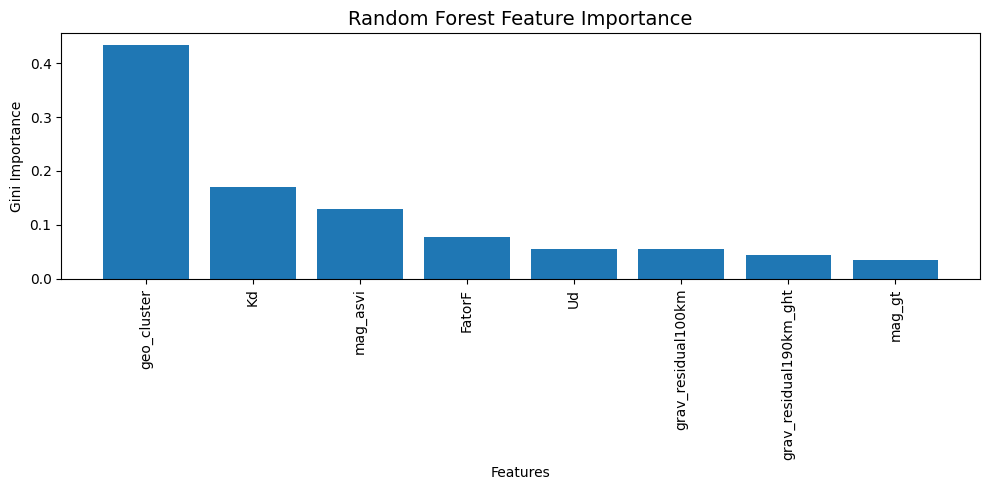

In [104]:
rf_model = pipeline.named_steps['classifier']

importances = rf_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Random Forest Feature Importance", fontsize=14)
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Gini Importance")
plt.tight_layout()
plt.show()

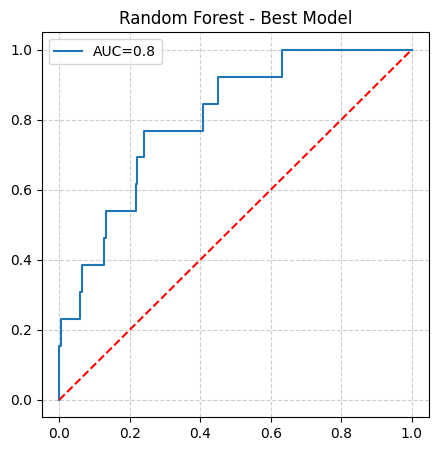

In [105]:
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# plot all this
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, label="AUC={}".format(round(roc_auc, 2)))
ax.plot([0, 1], [0, 1], "r--")
ax.legend()
ax.set_title("Random Forest - Best Model")
ax.grid(visible=True, alpha=0.6, linestyle="--")
plt.show()

### SHAP

Ref: https://shap.readthedocs.io/en/latest/

In [106]:
feature_names = X_train.columns.tolist()

explainer = shap.Explainer(rf_model)
shap_values = explainer(X_train)
shap_values_pos = shap_values[1]

In [107]:
print(f"Data shape: {X_train.shape}")
print(f"All SHAP values shape: {np.array(shap_values).shape}")
print(f"SHAP values for class 1: {shap_values.shape}")

Data shape: (822, 8)
All SHAP values shape: (822, 8)
SHAP values for class 1: (822, 8)


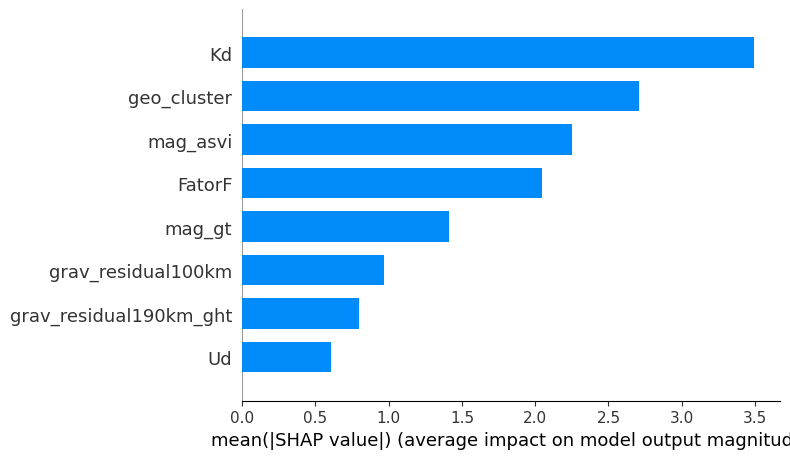

In [108]:
shap.summary_plot(
    shap_values,
    pd.DataFrame(X_train, columns=X_train.columns),
    feature_names=X_train.columns.tolist(),
    plot_type="bar",
)

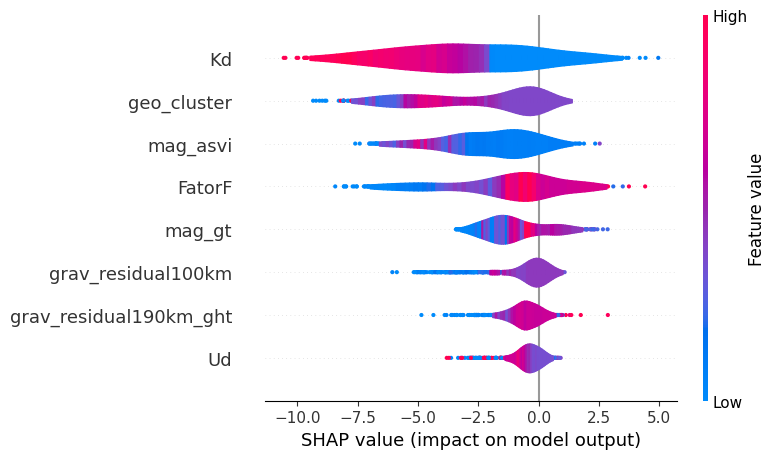

In [109]:
shap.summary_plot(
    shap_values, pd.DataFrame(X_train, columns=X_train.columns), plot_type="violin"
)

### Mapa

In [110]:
coord_df = pd.DataFrame.from_dict(dict_map_idx_lon, orient="index")
coord_df["latitude"] = dict_map_idx_lat
coord_df.columns = ["longitude", "latitude"]
coord_df.head(3)

,longitude,latitude
0,-50.50,-5.95
1,-51.88,-6.49
2,-51.39,-6.51


In [111]:
results = X_test.copy()
results["probability"] = y_proba
results["prediction"] = y_pred_custom
results.head(3)

,geo_cluster,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,probability,prediction
425,1,0.088365,0.498377,0.495197,0.000726,3.253272,906.429382,0.452149,0.000472,0
927,7,0.083549,-0.983150,-0.695050,0.000086,-13.548951,63.895351,0.023870,0.000124,0
942,6,0.015140,-3.563424,-0.695464,0.000716,-1.844845,50.014801,0.011086,0.003009,0


In [112]:
results = pd.merge(results, coord_df, left_index=True, right_index=True, how="inner")
results.head(3)

,geo_cluster,FatorF,Kd,Ud,grav_residual190km_ght,grav_residual100km,mag_asvi,mag_gt,probability,prediction,longitude,latitude
425,1,0.088365,0.498377,0.495197,0.000726,3.253272,906.429382,0.452149,0.000472,0,-49.81,-6.31
927,7,0.083549,-0.983150,-0.695050,0.000086,-13.548951,63.895351,0.023870,0.000124,0,-51.66,-6.13
942,6,0.015140,-3.563424,-0.695464,0.000716,-1.844845,50.014801,0.011086,0.003009,0,-49.84,-5.68


In [113]:
mineral_locations = results[results["prediction"] == 1]
print(f"Locais com alta confiança de cobre: {len(mineral_locations)}")

Locais com alta confiança de cobre: 27


In [114]:
# https://python-visualization.github.io/folium/latest/user_guide/raster_layers/tiles.html
fig = Figure(width=700, height=600)

m = folium.Map(
    location=[mineral_locations["latitude"].mean(), mineral_locations["longitude"].mean()],
    zoom_start=7,
)

for _, row in df_minas.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="red", fill=True, tooltip="Mina"
    ).add_to(m)


for _, row in df_minerio.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]], radius=5, color="sienna", fill=True, tooltip="Cobre"
    ).add_to(m)


for _, row in mineral_locations.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color="lightcoral",
        fill=True,
        tooltip=f"Cobre Prob: {row['probability']:.3f}",
    ).add_to(m)


fig.add_child(m)